# Local sensitivity

The goal of this notebook is to implement the calculation of local sensitvity form scratch. It is benchmarked against the results of the global sensitivity from my previos [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/My_implementations/Global_sensitivity/Global_Sensitivity.ipynb). 

Local sensitivity differs from global sensitivity in that it considers only the dataset to be released, and not all the possible release datasets. Furthermore, you only calculate the neighbors of the release dataset, and not of all possible datasets. And it is only with these neighbors and the release dataset that you find the maximum norm. 
Global sensitibvity is therefore an upper bound of local sensitivity. 

### Contributions of notebook

1. Two functions to calculate the local sensitivity of a dataset empirically.
2. Comparisons between local and global sensitivity results.

### Mean questions for clarification
- If local sensitivity would imply less noise due to its smaller value, then why do we not always use local sensitvity?  If for each dataset you would calculate its particular loca sensitvity, then adversary could also take that into consideration when plotting noise distributions of the different possible dataset release combinations. These distributions would have a lower std, and thus, once the adversary gets a query DP result, it would be easier for him/her to discard possible release datasets (A visual representation of this process carried out by an attacker is in the [paper](https://git.gnunet.org/bibliography.git/plain/docs/Choosing-%CE%B5-2011Lee.pdf) I implemented 2 blog posts ago, depicted in Figs. 1 and 3). That is why some researchers invented smooth bounds for local sensitivities, but that is something I will cover in future blog posts.

**TIP**: The best way to understand this notebook better is to open my previous [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/My_implementations/Global_sensitivity/Global_Sensitivity.ipynb) and go the visualizations of scenario (a), and to cell 25 for unbounded and cell 33 for unbounded sensitvity in order to compare the raw data.

## Datasets

In [1]:
# Visualization
%pylab inline
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt

# handling data
import csv
import json
import pandas as pd

# Math
from random import random
import scipy.stats as ss
import numpy as np
import itertools
from collections import Counter 

Populating the interactive namespace from numpy and matplotlib


### Datasets

We have 2 datsets to test our function:
- (a_s) A small one I can use to benchmark our functions against a published paper ["How much is enough? Choosing epsilon for Differential Privacy"](https://git.gnunet.org/bibliography.git/plain/docs/Choosing-%CE%B5-2011Lee.pdf). Which was implemented in on of my previous [blog posts](https://github.com/gonzalo-munillag/Blog/tree/main/Extant_Papers_Implementations/A_method_to_choose_epsilon).
- (a_l) A large one to test the functions further.

The use case will be records from the students in a school.

###### D_small 

In [2]:
# We define the actual dataset (conforming the universe)
D_small_universe_dict = {'name': ['Chris', 'Kelly', 'Pat', 'Terry'], 'school_year': [1, 2, 3, 4], 'absence_days': [1, 2, 3, 10]}

In [3]:
D_small_universe = pd.DataFrame(D_small_universe_dict)
D_small_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3
3,Terry,4,10


In [4]:
# We define the the dataset that we will release
D_small_release = D_small_universe.drop([3], axis=0)
D_small_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3


The adversary model adopted in the paper mentioned above is the worst-case scenario and it will be the one I adopted in this notebook: An attacker has infinite computation power, and because DP provides privacy given adversaries with arbitrary background knowledge, it is okay to assume that the adversary has full access to all the records (adversary knows all the universe, i.e. D_a_small_universe). But there is a dataset made from the universe without an individual (D_a_small_release), and the adversary does not know who is and who is not in it (this is the only thing the adversary does not know about the universe), but the adversary knows D_a_small_release contains people with a particular quality (the students who have not been in probation). With D_a_small_universe, the attacker will try to reconstruct the dataset he does not know (D_a_small_release) by employing queries on D_a_small_release without having access to it.

###### D_a_large

The larger dataset for the universe is used to test the functions with a hamming distance >1 and with a universe with duplicated values both in the univese and the release, which does not mean are the same records.

In [5]:
# We define the actual dataset (conforming the universe)
D_large_universe_dict = {'name': ['Chris', 'Kelly', 'Keny', 'Sherry', 'Jerry', 'Morty', "Beth", "Summer", "Squanchy", "Rick"], \
                     'school_year': [1, 2, 2, 2, 5, 5, 7, 8, 9, 9], 'absence_days': [1, 2, 3, 4, 5, 6, 7, 8, 15, 20]}

In [6]:
D_large_universe = pd.DataFrame(D_large_universe_dict)
D_large_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6
6,Beth,7,7
7,Summer,8,8
8,Squanchy,9,15
9,Rick,9,20


In [7]:
# We define the the dataset that we will release
D_large_release = D_large_universe.iloc[:6,:]
D_large_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6


## Functions

### Auxiliary function

##### Here we have all the queries we could make to the numerical data

In [8]:
# With this funciton, we can make easier to call the mean, median... functions
# REF: https://stackoverflow.com/questions/34794634/how-to-use-a-variable-as-function-name-in-python
# It is not clean to have the var percentile input each function, but it is less verbose than having a function
# For each percentile. We could however limit the maount of percentiles offer to 25 and 75.
class Query_class:  
    """
    A class used to represent a query. YOu instantiate an object that will perform a particlar query on an array

    Attributes
    ----------
    fDic - (dict) containing the possible queries the class can be transformed into
    fActive - (function) it contins the function we created the class to have

    Methods
    -------
    
    run_query - I will run the query for which we instantiated the class
    The other methods implement the different possible queries
    
    """
    
    def __init__(self, fCase):
        
        # mapping: string --> variable = function name
        fDic = {'mean':self._mean,         
                'median':self._median,
                'count': self._count,
                'sum': self._sum,
                'std': self._std,
                'var': self._var,
                'percentile': self._percentile}
        
        self.fActive = fDic[fCase]
    
    # Calculate the mean of an array
    def _mean(self, array, percentile): 

        return np.mean(array)
    
    # Calculate the median of an array
    def _median(self, array, percentile): 
        
        return np.median(array)
            
    # Calculate the number of elements in the array
    def _count(self, array, percentile):
        
        return len(array)
    
    # Calculate the sum of an array
    def _sum(self, array, percentile):
        
        return np.sum(array)
    
    # Calculate the std of an array
    def _std(self, array, percentile):
        
        return np.std(array)
    
    # Calculate the variance of an array
    def _var(self, array, percentile):
        
        return np.var(array)
    
    def _percentile(self, array, percentile):

        return np.percentile(array, percentile)
    
    # It will run the given query
    def run_query(self, array, percentile=50):
        
        return self.fActive(array, percentile)

In [9]:
# Set of checks on the input values
def verify_sensitivity_inputs(universe_cardinality, universe_subset_cardinality, hamming_distance):
    """
    INPUT:
        universe - (df) contains all possible values of the dataset
        universe_subset_cardinality - (df) cardinality of the universe subset
        hamming_distance - (int) hamming distance between neighboring datasets
        
    OUTPUT:
        ValueError - (str) error message due to the value of the inputs
        
    Description:
    It performs multiple checks to verify the validity of the inputs for the calculation of senstitivity
    """

    # Check on unverse cardinality (1). 
    # The cardinality of the subset of the universe cannot be larger than the universe 

    if universe_cardinality < universe_subset_cardinality:

        raise ValueError("Your universe dataset cannot be smaller than your release dataset.")
    
    # Checks on the validity of the chosen hamming_distance (3)
    if hamming_distance >= (universe_subset_cardinality):
        
        raise ValueError("Hamming distance chosen is larger than the cardinality of the release dataset.")

    if (hamming_distance > np.abs(universe_cardinality - universe_subset_cardinality)):
        
        raise ValueError("Hamming distance chosen is larger than the difference in cardinalities between the \
        universe and the release dataset, i.e., \
        there are not enough values in your universe to create such a large neighboring dataset (Re-sampling records).")
    
    # The hamming distance cannot be 0, then your neighbor dataset is equal to the original dataset
    if hamming_distance == 0:

        raise ValueError("Hamming distance cannot be 0.")

In [10]:
# Used by unbounded unbounded_empirical_global_L1_sensitivity_a
def L1_norm_max(release_dataset_query_value, neighbor_datasets, query, percentile):
    """
    INPUT:
        release_dataset_query_value - (float) query value of a particular possible release dataset
        neighbor_datasets - (list) contains the possible neighbors of the specific release dataset
        query - (object) instance of class Query_class
        percentile - (int) percentile value for the percentile query

        
    OUTPUT:
        L1_norm_maximum - (float) maximum L1 norm calcuated from the differences between the query results 
        of the neighbor datasets and the specific release dataset

    Description:
    It claculates the maximum L1 norm between the query results of the neighbor datasets and the specific release dataset
    """

    neighbor_dataset_query_values = []
    for neighbor_dataset in neighbor_datasets:

        neighbor_dataset_query_value = query.run_query(neighbor_dataset, percentile)
        neighbor_dataset_query_values.append(neighbor_dataset_query_value)

    # We select the maximum and minimum values of the queries, as the intermediate values will not 
    # yield a larger L1 norm (ultimately, we are interested in the maximum L1 norm)
    neighbor_dataset_query_value_min, neighbor_dataset_query_value_max = \
    min(neighbor_dataset_query_values), max(neighbor_dataset_query_values)
    # We calculate the L1 norm for these two values and pick the maximum
    L1_norm_i = np.abs(release_dataset_query_value - neighbor_dataset_query_value_min)
    L1_norm_ii = np.abs(release_dataset_query_value - neighbor_dataset_query_value_max)
    L1_norm_maximum = max(L1_norm_i, L1_norm_ii)
        
    return L1_norm_maximum

In [36]:
def calculate_unbounded_sensitivities(universe, universe_subset, columns, hamming_distance, unbounded_sensitivities):
    """
    INPUT:
        universe - (df or dict) contains all possible values of the dataset
        universe_subset - (df) contains subset chosen for the release dataset
        columns - (array) contains the names of the columns we would like to obtain the sensitivity from
        hamming_distance - (int) hamming distance between neighboring datasets
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type
    
    OUTPUT
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type

    Description:
    It calculates the sensitivities for a set of queries given a universe and a release dataset.
    """
    # Calculate the sensitivity of different queries for the unbounded DP
    query_type = 'mean'
    mean_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'median'
    median_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'count'
    count_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'sum'
    sum_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'std'
    std_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'var'
    var_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'percentile'
    percentile = 25
    percentile_25_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance, percentile)
    percentile = 50
    percentile_50_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance, percentile)
    percentile = 75
    percentile_75_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance, percentile)
    percentile = 90
    percentile_90_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance, percentile)

    print('Unbounded sensitivities for mean', mean_unbounded_global_sensitivities)
    print('Unbounded sensitivities for median', median_unbounded_global_sensitivities)
    print('Unbounded sensitivities for count', count_unbounded_global_sensitivities)
    print('Unbounded sensitivities for sum', sum_unbounded_global_sensitivities)
    print('Unbounded sensitivities for std', std_unbounded_global_sensitivities)
    print('Unbounded sensitivities for var', var_unbounded_global_sensitivities)
    print('Unbounded sensitivities for percentile 25', percentile_25_unbounded_global_sensitivities)
    print('Unbounded sensitivities for percentile 50', percentile_50_unbounded_global_sensitivities)
    print('Unbounded sensitivities for percentile 75', percentile_75_unbounded_global_sensitivities)
    print('Unbounded sensitivities for percentile 90', percentile_90_unbounded_global_sensitivities)
    
    unbounded_sensitivities = build_sensitivity_dict(unbounded_sensitivities, hamming_distance,\
    mean_unbounded_global_sensitivities, median_unbounded_global_sensitivities, count_unbounded_global_sensitivities, \
    sum_unbounded_global_sensitivities, std_unbounded_global_sensitivities, var_unbounded_global_sensitivities, \
    percentile_25_unbounded_global_sensitivities, percentile_50_unbounded_global_sensitivities, \
    percentile_75_unbounded_global_sensitivities, percentile_90_unbounded_global_sensitivities)
    
    return unbounded_sensitivities

In [48]:
def calculate_bounded_sensitivities(universe, universe_subset, columns, hamming_distance, bounded_sensitivities):
    """
    INPUT:
        universe - (df or dict) contains all possible values of the dataset
        universe_subset - (df) contains subset chosen for the release dataset
        columns - (array) contains the names of the columns we would like to obtain the sensitivity from
        hamming_distance - (int) hamming distance between neighboring datasets
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type
    
    OUTPUT
        bounded_sensitivities - (dict) stores sensitivities per hamming distance and query type

    Description:
    It calculates the sensitivities for a set of queries given a universe and a release dataset.
    """
    # Calculate the sensitivity of different queries for the unbounded DP
    query_type = 'mean'
    mean_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'median'
    median_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'count'
    count_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'sum'
    sum_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'std'
    std_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'var'
    var_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance)
    query_type = 'percentile'
    percentile = 25
    percentile_25_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance, percentile)
    percentile = 50
    percentile_50_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance, percentile)
    percentile = 75
    percentile_75_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance, percentile)
    percentile = 90
    percentile_90_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns,  query_type, hamming_distance, percentile)

    print('Bounded sensitivities for mean', mean_bounded_global_sensitivities)
    print('Bounded sensitivities for median', median_bounded_global_sensitivities)
    print('Bounded sensitivities for count', count_bounded_global_sensitivities)
    print('Bounded sensitivities for sum', sum_bounded_global_sensitivities)
    print('Bounded sensitivities for std', std_bounded_global_sensitivities)
    print('Bounded sensitivities for var', var_bounded_global_sensitivities)
    print('Bounded sensitivities for percentile 25', percentile_25_bounded_global_sensitivities)
    print('Bounded sensitivities for percentile 50', percentile_50_bounded_global_sensitivities)
    print('Bounded sensitivities for percentile 75', percentile_75_bounded_global_sensitivities)
    print('Bounded sensitivities for percentile 90', percentile_90_bounded_global_sensitivities)
    
    bounded_sensitivities = build_sensitivity_dict(bounded_sensitivities, hamming_distance,\
    mean_bounded_global_sensitivities, median_bounded_global_sensitivities, count_bounded_global_sensitivities, \
    sum_bounded_global_sensitivities, std_bounded_global_sensitivities, var_bounded_global_sensitivities, \
    percentile_25_bounded_global_sensitivities, percentile_50_bounded_global_sensitivities, \
    percentile_75_bounded_global_sensitivities, percentile_90_bounded_global_sensitivities)
    
    return bounded_sensitivities

In [13]:
# We save the values in a dictionary
def build_sensitivity_dict(unbounded_sensitivities, hamming_distance, mean_sensitivity, median_sensitivity, count_sensitivity, _sum_sensitivity, _std_sensitivity, _var_sensitivity, percentile_25_sensitivity, percentile_50_sensitivity, percentile_75_sensitivity, percentile_90_sensitivity):
    """
    INPUT
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type
        hamming_distance - (int) hamming distance of the neighboring datasets
        mean_sensitivity - (float) sensitivity of the mean query 
        median_sensitivity - (float) sensitivity of the media query 
        count_sensitivity - (float) sensitivity of the count query 
        _sum_sensitivity - (float) sensitivity of the sum query 
        _std_sensitivity - (float) sensitivity of the std query 
        _var - (float) sensitivity of the var query 
        percentile_25_sensitivity - (float) sensitivity of the percentile 25 query 
        percentile_50_sensitivity - (float) sensitivity of the percentile 50 query 
        percentile_75_sensitivity - (float) sensitivity of the percentile 75query 
        percentile_90_sensitivity - (float) sensitivity of the percentile 90 query 

    OUTPUT
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type
    
    """
    unbounded_sensitivities[hamming_distance] = {}
    unbounded_sensitivities[hamming_distance]['mean'] = mean_sensitivity
    unbounded_sensitivities[hamming_distance]['median'] = median_sensitivity
    unbounded_sensitivities[hamming_distance]['count'] = count_sensitivity
    unbounded_sensitivities[hamming_distance]['sum'] = _sum_sensitivity
    unbounded_sensitivities[hamming_distance]['std'] = _std_sensitivity
    unbounded_sensitivities[hamming_distance]['var'] = _var_sensitivity
    unbounded_sensitivities[hamming_distance]['percentile_25'] = percentile_25_sensitivity
    unbounded_sensitivities[hamming_distance]['percentile_50'] = percentile_50_sensitivity
    unbounded_sensitivities[hamming_distance]['percentile_75'] = percentile_75_sensitivity
    unbounded_sensitivities[hamming_distance]['percentile_90'] = percentile_90_sensitivity
    
    return unbounded_sensitivities

##  Main Functions 

### Unbounded Local Sensitivity 

In [14]:
%%latex
\begin{align}
\ell_{1, \mbox{sensitivity}}: LS(x) =\max_{\substack{
{y \in \mathbb{N}^{(\mathcal{X})}} \\
\|x-y\|_{1} = h \\
||x|-|y|| = h
}} \|f(x)-f(y)\|_{1}
\end{align}

<IPython.core.display.Latex object>

\begin{align}
\ell_{1, \mbox{sensitivity}}: LS(x) =\max_{\substack{
{y \in \mathbb{N}^{(\mathcal{X})}} \\
\|x-y\|_{1} = h \\
||x|-|y|| = h
}} \|f(x)-f(y)\|_{1}
\end{align}

In [15]:
def unbounded_empirical_local_L1_sensitivity(universe, universe_subset, columns, query_type, hamming_distance, percentile=50):
    """
    INPUT:
        universe - (df ot dict) contains all possible values of the dataset
        universe_subset - (df or dict) contains the subset chosen for the release dataset
        columns - (array) contains the names of the columns we would like to obtain the sensitivity from
        query_type - (str) contain the category declaring the type of query to be later on executed
        hamming_distance - (int) hamming distance between neighboring datasets
        percentile - (int) percentile value for the percentile query
        
    OUTPUT:
        unbounded_global_sensitivity - (float) the unbounded global sensitivity of the input universe
        
    Description:
    It claculates the global sensitivity of an array based on the knowledge of the entire universe of 
    the dataset and query_type.
    """
    # Check if the values for the hamming distance and universe sizes comply with the basic constraints
    # verify_sensitivity_inputs(universe.shape[0], universe_subset.shape[0], hamming_distance)
    verify_sensitivity_inputs(universe.shape[0], universe_subset.shape[0], hamming_distance)

    # We initialie the type of query for which we would like calculate the sensitivity
    query = Query_class(query_type)
    
    # We will store the sensitivity of each column of the dataset containing universe in a dictionary
    unbounded_global_sensitivity_per_colum = {}
    
    for column in columns:
                
        # 1) RELEASE DATASET /// it could be a dataframe or a tupple
        try:
            release_dataset = universe_subset[column]
        except:
            release_dataset = universe_subset

        # 2) |NEIGHBORING DATASET| < |RELEASE DATASET| //// cardinalities           
        neighbor_with_less_records_datasets = itertools.combinations(release_dataset, \
            universe_subset.shape[0] - hamming_distance)
        neighbor_with_less_records_datasets = list(neighbor_with_less_records_datasets)
               
        # 3) |NEIGHBORING DATASET| > |RELEASE DATASET| //// cardinalities           
        symmetric_difference = list((Counter(universe[column]) - Counter(release_dataset)).elements())
        neighbor_possible_value_combinations = itertools.combinations(symmetric_difference, hamming_distance)
        neighbor_possible_value_combinations = list(neighbor_possible_value_combinations)

        neighbor_with_more_records_datasets = []
        for neighbor_possible_value_combination in neighbor_possible_value_combinations:

            # We create neighboring datasets by concatenating the neighbor_possible_value_combination with the release dataset
            neighbor_with_more_records_dataset = np.append(release_dataset, neighbor_possible_value_combination)
            neighbor_with_more_records_datasets.append(neighbor_with_more_records_dataset)          
        
        # 4) For each possible release datase, there is a set of neighboring datasets 
        # We will iterate through each possible release dataset and calculate the L1 norm with 
        # each of its repspective neighboring datasets
        L1_norms = []

        release_dataset_query_value = query.run_query(release_dataset, percentile)

        L1_norm =  L1_norm_max(release_dataset_query_value, neighbor_with_less_records_datasets, query, percentile)
        L1_norms.append(L1_norm)
        L1_norm =  L1_norm_max(release_dataset_query_value, neighbor_with_more_records_datasets, query, percentile)
        L1_norms.append(L1_norm)
        
        # We pick the maximum out of all the maximum L1_norms calculated from each possible release dataset
        unbounded_global_sensitivity_per_colum[column] = max(L1_norms)
        
    return unbounded_global_sensitivity_per_colum

### Bounded Local Sensitivity

In [16]:
%%latex
\begin{align}
\ell_{1, \mbox{sensitivity}}: LS(x) =\max_{\substack{
{y \in \mathbb{N}^{(\mathcal{X})}} \\
\|x-y\|_{1} = h \\
||x|-|y|| = 0
}} \|f(x)-f(y)\|_{1}
\end{align}

<IPython.core.display.Latex object>

\begin{align}
\ell_{1, \mbox{sensitivity}}: LS(x) =\max_{\substack{
{y \in \mathbb{N}^{(\mathcal{X})}} \\
\|x-y\|_{1} = h \\
||x|-|y|| = 0
}} \|f(x)-f(y)\|_{1}
\end{align}

In [17]:
def bounded_empirical_local_L1_sensitivity(universe, universe_subset, columns, query_type, hamming_distance, percentile=50):
    """
    INPUT:
        universe - (df) contains all possible values of the dataset
        universe_subset - (df or dict) contains the subset chosen for the release dataset
        columns - (array) contains the names of the columns we would like to obtain the sensitivity from
        query_type - (str) contain the category declaring the type of query to be later on executed
        hamming_distance - (int) hamming distance between neighboring datasets
        percentile - (int) percentile value for the percentile query

    OUTPUT:
        bounded_global_sensitivity - (float) the bounded global sensitivity of the input universe
        
    Description:
    It claculates the global sensitivity of an array based on the knowledge of the entire universe of 
    the dataset and query_type.
    """
    
    # Check if the values for the hamming distance and universe sizes comply with the basic constraints
    verify_sensitivity_inputs(universe.shape[0], universe_subset.shape[0], hamming_distance)
    
    # We initialie the type of query for which we would like calculate the sensitivity
    query = Query_class(query_type)
    
    # We will store the sensitivity of each column of the dataset containing universe in a dictionary
    bounded_global_sensitivity_per_column = {}
    
    for column in columns:
        
        # We calculate all the possible release datasets
        # First we obtain the combinations within the release dataset. The size of this combinations is not the original size
        # but the original size minus the hamming_distance /// it could be a dataframe or a tupple
        try:
            
            release_i_datasets = itertools.combinations(universe_subset[column], universe_subset.shape[0] - hamming_distance)
        
        except:
            
            release_i_datasets = itertools.combinations(universe_subset, universe_subset.shape[0] - hamming_distance)

        release_i_datasets = list(release_i_datasets)
        
        # it will contain sets of neighboring datasets. The L1 norm will be calculated between these sets. The maximum will be chosen
        # The datasets from different groups do not necesarilly need to be neighbors, thus we separate them in groups
        neighbor_dataset_groups = []
        for release_i_dataset in release_i_datasets:

            # second we calculate the combinations of the items in the universe that are not in the release dataset
            # the size of a combination is equal to the hamming distance. This will not discard duplicates
            symmetric_difference = list((Counter(universe[column]) - Counter(release_i_dataset)).elements())
            release_ii_datasets = itertools.combinations(symmetric_difference, hamming_distance)
            release_ii_datasets = list(release_ii_datasets)
            
            # We create neighboring datasets by concatenating i with ii
            neighbor_datasets = []
            for release_ii_dataset in release_ii_datasets:

                neighbor = list(release_i_dataset + release_ii_dataset)
                neighbor_datasets.append(neighbor)   
            
            neighbor_dataset_groups.append(neighbor_datasets)

        # We calculate the L1_norm for the different combinations with the aim to find the max
        # We can loop in this manner because we are obtaining the absolute values
        L1_norms = []
        for m in range(0, len(neighbor_dataset_groups)):
        
            for i in range(0,  len(neighbor_dataset_groups[m])-1):

                for j in range(i+1, len(neighbor_dataset_groups[m])):

                    L1_norm = np.abs(query.run_query(neighbor_dataset_groups[m][i], percentile) - query.run_query(neighbor_dataset_groups[m][j], percentile))
                    L1_norms.append(L1_norm)

            bounded_global_sensitivity_per_column[column] = max(L1_norms)

    return bounded_global_sensitivity_per_column

## MAIN 

### Unbounded sensitivity - Scenario a

Side Note: I comment off and on the printing script for sensitivities depending on the verbosity needed per explanation.

Let us begin with the small dataset and a hamming distance of 1 (the only one it allows given the shapes of the release and universe dataset)

In [21]:
D_small_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3


In [22]:
D_small_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3
3,Terry,4,10


##### In the [paper](https://git.gnunet.org/bibliography.git/plain/docs/Choosing-%CE%B5-2011Lee.pdf) mentioned, Table 4 shows the local sensitivities for different possible worlds. Let us check them one by one:

##### For {1, 2, 3}, the local sensitivity of the median should be 0.5 for absence_days:

In [20]:
columns = ['school_year', 'absence_days']
hamming_distance = 1
unbounded_sensitivities = {}
unbounded_sensitivities = calculate_unbounded_sensitivities(D_small_universe, D_small_release, columns, hamming_distance, unbounded_sensitivities)
unbounded_sensitivities[hamming_distance]['median']

Unbounded sensitivities for mean {'school_year': 0.5, 'absence_days': 2.0}
Unbounded sensitivities for median {'school_year': 0.5, 'absence_days': 0.5}
Unbounded sensitivities for count {'school_year': 1, 'absence_days': 1}
Unbounded sensitivities for sum {'school_year': 4, 'absence_days': 10}
Unbounded sensitivities for std {'school_year': 0.31649658092772603, 'absence_days': 2.7190373250050115}
Unbounded sensitivities for var {'school_year': 0.5833333333333334, 'absence_days': 11.833333333333334}
Unbounded sensitivities for percentile 25 {'school_year': 0.75, 'absence_days': 0.75}
Unbounded sensitivities for percentile 50 {'school_year': 0.5, 'absence_days': 0.5}
Unbounded sensitivities for percentile 75 {'school_year': 0.75, 'absence_days': 2.25}
Unbounded sensitivities for percentile 90 {'school_year': 0.9000000000000004, 'absence_days': 5.100000000000001}


{'school_year': 0.5, 'absence_days': 0.5}

My function works as intended for the benchmark dataset. The results for median are the same as in the paper.  The paper does not deal with other types of queries. (We also get the percentile 50 to cross-check with the median).
I printed the other queries so you can have a look at them as well, I will however stop printing all of them in the next cells.

##### For {1, 2, 10}, the local sensitivity of the median should be 4  for absence_days:

In [24]:
D_small_release_test = D_small_release
D_small_release_test = D_small_release_test.drop(['absence_days'], axis=1)
D_small_release_test['absence_days'] = [1, 2, 10]
D_small_release_test

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,10


In [25]:
unbounded_sensitivities = {}
unbounded_sensitivities = calculate_unbounded_sensitivities(D_small_universe, D_small_release_test, columns, hamming_distance, unbounded_sensitivities)
unbounded_sensitivities[hamming_distance]['median']

{'school_year': 0.5, 'absence_days': 4.0}

##### For {1, 3, 10}, the local sensitivity of the median should be 3.5 for absence_days:

In [26]:
D_small_release_test = D_small_release
D_small_release_test = D_small_release_test.drop(['absence_days'], axis=1)
D_small_release_test['absence_days'] = [1, 3, 10]
D_small_release_test

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,3
2,Pat,3,10


In [27]:
unbounded_sensitivities = {}
unbounded_sensitivities = calculate_unbounded_sensitivities(D_small_universe, D_small_release_test, columns, hamming_distance, unbounded_sensitivities)
unbounded_sensitivities[hamming_distance]['median']

{'school_year': 0.5, 'absence_days': 3.5}

##### For {2, 3, 10}, the local sensitivity of the median should be 3.5:

In [28]:
D_small_release_test = D_small_release
D_small_release_test = D_small_release_test.drop(['absence_days'], axis=1)
D_small_release_test['absence_days'] = [2, 3, 10]
D_small_release_test

,name,school_year,absence_days
0,Chris,1,2
1,Kelly,2,3
2,Pat,3,10


In [29]:
unbounded_sensitivities = {}
unbounded_sensitivities = calculate_unbounded_sensitivities(D_small_universe, D_small_release_test, columns, hamming_distance, unbounded_sensitivities)
unbounded_sensitivities[hamming_distance]['median']

{'school_year': 0.5, 'absence_days': 3.5}

Each of these tests have passed. And the maximum of these local sensitivities, is the global sensitivity, as explained in the paper. This would be 4, if we scroll down in my other [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/Extant_Papers_Implementations/A_method_to_choose_epsilon/How_much_is_enough_Calculating_An_Optimal_Epsilon.ipynb) to point MEDIAN, you will see that for unbounded sensitivity we calculated also 4. 

In [30]:
%%latex
\begin{align}
\ell_{1, \mbox{sensitivity}}: \Delta f=\max_{\substack{
{x \in \mathbb{N}^{(\mathcal{X})}} \\
}} LS(x)
\end{align}

<IPython.core.display.Latex object>

\begin{align}
\ell_{1, \mbox{sensitivity}}: \Delta f=\max_{\substack{
{x \in \mathbb{N}^{(\mathcal{X})}} \\
}} LS(x)
\end{align}

we could therefore loop through all the combinations of release datasets and apply our local sensitivity function. We would only need to pick the maximum L1 norm.

#### Let us try our function with a larger dataset, which it also allows for a larger hamming distance.

In [32]:
D_large_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6
6,Beth,7,7
7,Summer,8,8
8,Squanchy,9,15
9,Rick,9,20


In [33]:
D_large_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6


In [37]:
columns = ['school_year', 'absence_days']
hamming_distances = [1, 2, 3, 4]
unbounded_sensitivities = {}

for hamming_distance in hamming_distances:
    
    print('Hamming distance = ', hamming_distance)
    unbounded_sensitivities = calculate_unbounded_sensitivities(D_large_universe, D_large_release, columns, hamming_distance, unbounded_sensitivities)


Hamming distance =  1
Unbounded sensitivities for mean {'school_year': 0.8809523809523809, 'absence_days': 2.3571428571428568}
Unbounded sensitivities for median {'school_year': 0.0, 'absence_days': 0.5}
Unbounded sensitivities for count {'school_year': 1, 'absence_days': 1}
Unbounded sensitivities for sum {'school_year': 9, 'absence_days': 20}
Unbounded sensitivities for std {'school_year': 1.0306508339365563, 'absence_days': 4.278553969413484}
Unbounded sensitivities for var {'school_year': 4.303287981859411, 'absence_days': 32.92006802721088}
Unbounded sensitivities for percentile 25 {'school_year': 0.0, 'absence_days': 0.75}
Unbounded sensitivities for percentile 50 {'school_year': 0.0, 'absence_days': 0.5}
Unbounded sensitivities for percentile 75 {'school_year': 2.25, 'absence_days': 0.75}
Unbounded sensitivities for percentile 90 {'school_year': 1.6000000000000014, 'absence_days': 6.100000000000005}
Hamming distance =  2
Unbounded sensitivities for mean {'school_year': 1.5416666

##### For the comparison of values you may check cell 24 of the notebook of my previous [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/My_implementations/Global_sensitivity/Global_Sensitivity.ipynb)

### Visualization

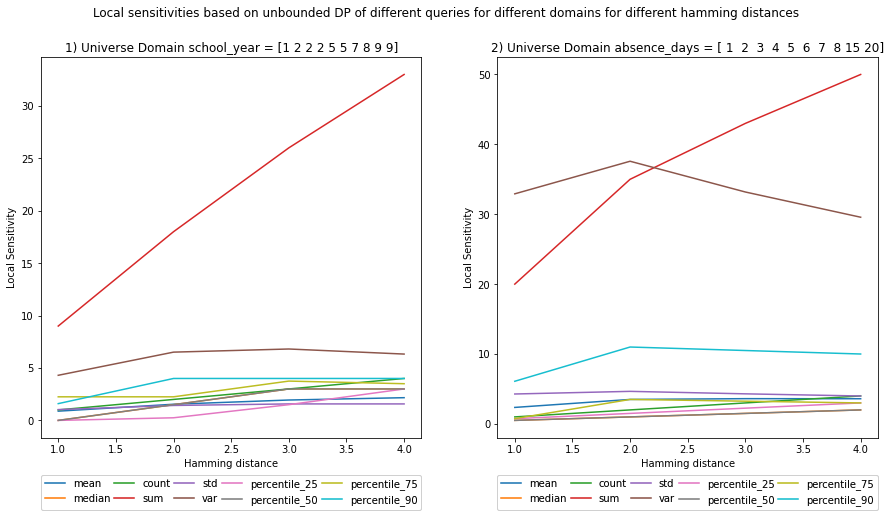

''

In [38]:
plt.figure(figsize=(15, 7))
 
query_types = ['mean', 'median', 'count', 'sum', 'std', 'var', 'percentile_25', 'percentile_50', 'percentile_75', 'percentile_90']

x_values = []
for key in unbounded_sensitivities.keys():
    
    x_values.append(key)
    
for inedx_column, column in enumerate(columns):
    
    # Start the plot
    plot_index = int(str(1) + str(len(columns)) + str(inedx_column+1))
    plt.subplot(plot_index)
    
    query_type_legend_handles = []
    for query_type in query_types:
        
        y_values = []
        for hamming_distance in unbounded_sensitivities.keys():
                           
            y_values.append(unbounded_sensitivities[hamming_distance][query_type][column])   
            
        # plot the sensitivities
        legend_handle, = plt.plot(x_values, y_values, label=query_type)
        query_type_legend_handles.append(legend_handle)
        
    # Legends
    legend = plt.legend(handles=query_type_legend_handles, bbox_to_anchor=(0., -0.2, 1., .102), \
                        ncol=5, mode="expand", borderaxespad=0.)
    legend_plot = plt.gca().add_artist(legend)
    
    # axis labels and titles
    plt.xlabel('Hamming distance')
    plt.ylabel('Local Sensitivity')
    plt.title('{}) Universe Domain {} = {}'.format(inedx_column+1, column, D_large_universe[column].values))

plt.suptitle('Local sensitivities based on unbounded DP of different queries for different domains for different hamming distances')
plt.show()
;

##### For the comparison of plots you may check cell 26 of the notebook of my previous [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/My_implementations/Global_sensitivity/Global_Sensitivity.ipynb)

It is interesting to see that the sensitivity for variance declines and at least for the sum the local sensitivity seems to be equal to the global sensitivity. The rest have lower values. This means that this particular dataset is the one with the maximum sensitivity for sum. 

Looking at the raw data, you might have thought that perhaps if the dataset is the one that provides maximum local sensitivity for a particular hamming distance and query, then it is also the maximum for the rest of the values of the hamming distance. But I can corroborate in the next set of raw data for unbounded sensitivity that that is not true, e.g. you will see the median sometimes is the maximum local sensitivity and sometimes not.

Let us find the global sensitivity for a hamming distance of 1 iterating through all the possible combinations of the release dataset. Afterward, we will make a comparison with prior results. (I will comment the printing of sensitivity results for getting less verbose outputs)

In [39]:
# We set the hamming distance and arrays to save the sensitivities
hamming_distance = 1
median_local_sensitivities = {}
unbounded_sensitivities = {}
columns = ['school_year', 'absence_days']
query_type = 'median'

for column in columns:
    
    # We get all the possible release datasets based on the universe
    release_datasets = itertools.combinations(D_large_universe[column], D_large_release.shape[0])
    release_datasets = list(release_datasets)
    
    median_local_sensitivities[column] = []
    for release_dataset in release_datasets:

        # I transform the release_dataset in the according format
        release_dataset = pd.Series(release_dataset)
        median_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(D_large_universe, release_dataset, columns,  query_type, hamming_distance)
        median_local_sensitivities[column].append(median_unbounded_global_sensitivities[column])    

In [40]:
for column in columns:
    
    max_sensitivity = np.max(median_local_sensitivities[column])
    print('Max local sensitivity (=global sensitivity) of {} is {}'.format(column, max_sensitivity))

Max local sensitivity (=global sensitivity) of school_year is 3.0
Max local sensitivity (=global sensitivity) of absence_days is 2.5


##### Find these results in cell 25 of [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/My_implementations/Global_sensitivity/Global_Sensitivity.ipynb). Look into hamming distance 1 and median: 3 and 2.5
Here are the results for a hamming distance of 2, also obtaining equal resuls as in the previous blog post: 3.5 and 6.

In [43]:
# We set the hamming distance and arrays to save the sensitivities
hamming_distance = 2
median_local_sensitivities = {}
unbounded_sensitivities = {}
columns = ['school_year', 'absence_days']
query_type = 'median'

for column in columns:
    
    # We get all the possible release datasets based on the universe
    release_datasets = itertools.combinations(D_large_universe[column], D_large_release.shape[0])
    release_datasets = list(release_datasets)
    
    median_local_sensitivities[column] = []
    for release_dataset in release_datasets:

        # I transform the release_dataset in the according format
        release_dataset = pd.Series(release_dataset)
        median_unbounded_global_sensitivities = unbounded_empirical_local_L1_sensitivity(D_large_universe, release_dataset, columns,  query_type, hamming_distance)
        median_local_sensitivities[column].append(median_unbounded_global_sensitivities[column])    

In [44]:
for column in columns:
    
    max_sensitivity = np.max(median_local_sensitivities[column])
    print('Max local sensitivity (=global sensitivity) of {} is {}'.format(column, max_sensitivity))

Max local sensitivity (=global sensitivity) of school_year is 3.5
Max local sensitivity (=global sensitivity) of absence_days is 6.0


### Bounded local sensitivity 

Let us begin with the small dataset and a hamming distance of 1 (the only one it allows given the shapes of the release and universe dataset)

In [49]:
D_small_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3


In [50]:
D_small_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3
3,Terry,4,10


##### For {1, 2, 3}, the local sensitivity of the median should be 1 for absence_days (above inequality 16 of point 6 of the paper):

In [51]:
columns = ['school_year', 'absence_days']
hamming_distance = 1
bounded_sensitivities = {}
bounded_sensitivities = calculate_bounded_sensitivities(D_small_universe, D_small_release, columns, hamming_distance, bounded_sensitivities)

Bounded sensitivities for mean {'school_year': 1.0, 'absence_days': 3.0}
Bounded sensitivities for median {'school_year': 1.0, 'absence_days': 1.0}
Bounded sensitivities for count {'school_year': 0, 'absence_days': 0}
Bounded sensitivities for sum {'school_year': 3, 'absence_days': 9}
Bounded sensitivities for std {'school_year': 0.430722547996921, 'absence_days': 3.2111854102704642}
Bounded sensitivities for var {'school_year': 0.8888888888888887, 'absence_days': 15.555555555555555}
Bounded sensitivities for percentile 25 {'school_year': 1.0, 'absence_days': 1.0}
Bounded sensitivities for percentile 50 {'school_year': 1.0, 'absence_days': 1.0}
Bounded sensitivities for percentile 75 {'school_year': 1.0, 'absence_days': 4.0}
Bounded sensitivities for percentile 90 {'school_year': 0.9999999999999996, 'absence_days': 5.799999999999999}


Note that these values are equal to the ones obtained with global sensitivity this is because, the universe is very small in comparison to the release dataset (differ in cardinality 1), so the neighbors of all the possible release datasets are the same. Thus, it does not matter that you do local or global sensitivity in this case.

#### Let us try our function with a larger dataset and with a larger hamming distance.

In [52]:
D_large_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6
6,Beth,7,7
7,Summer,8,8
8,Squanchy,9,15
9,Rick,9,20


In [53]:
D_large_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6


Find the results in cell 33 of [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/My_implementations/Global_sensitivity/Global_Sensitivity.ipynb) in order to compare them to these. You will see that some of them are equal (this dataset in particular provides max local sensitivity for a particular hamming distance and query, and some are smaller, never larger). 

In [54]:
columns = ['school_year', 'absence_days']
hamming_distances = [1, 2, 3, 4]
bounded_sensitivities = {}

for hamming_distance in hamming_distances:
    
    print('Hamming distance = ', hamming_distance)
    bounded_sensitivities = calculate_bounded_sensitivities(D_large_universe, D_large_release, columns, hamming_distance, bounded_sensitivities)


Hamming distance =  1
Bounded sensitivities for mean {'school_year': 1.3333333333333335, 'absence_days': 3.166666666666667}
Bounded sensitivities for median {'school_year': 1.5, 'absence_days': 1.0}
Bounded sensitivities for count {'school_year': 0, 'absence_days': 0}
Bounded sensitivities for sum {'school_year': 8, 'absence_days': 19}
Bounded sensitivities for std {'school_year': 1.1814550849669505, 'absence_days': 4.757896452763675}
Bounded sensitivities for var {'school_year': 5.111111111111111, 'absence_days': 38.8888888888889}
Bounded sensitivities for percentile 25 {'school_year': 0.0, 'absence_days': 1.0}
Bounded sensitivities for percentile 50 {'school_year': 1.5, 'absence_days': 1.0}
Bounded sensitivities for percentile 75 {'school_year': 0.75, 'absence_days': 1.0}
Bounded sensitivities for percentile 90 {'school_year': 2.0, 'absence_days': 7.5}
Hamming distance =  2
Bounded sensitivities for mean {'school_year': 2.4999999999999996, 'absence_days': 5.333333333333334}
Bounded s

### Visualization

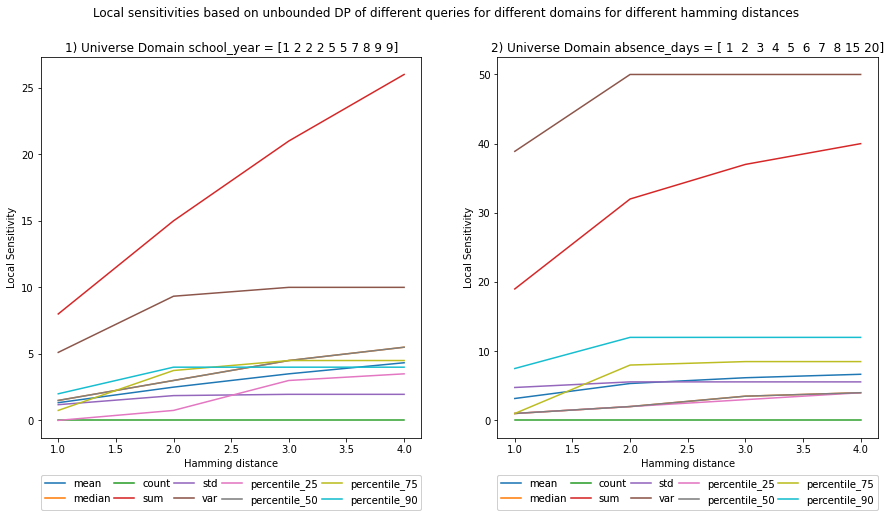

''

In [55]:
plt.figure(figsize=(15, 7))
 
query_types = ['mean', 'median', 'count', 'sum', 'std', 'var', 'percentile_25', 'percentile_50', 'percentile_75', 'percentile_90']

x_values = []
for key in bounded_sensitivities.keys():
    
    x_values.append(key)
    
for inedx_column, column in enumerate(columns):
    
    # Start the plot
    plot_index = int(str(1) + str(len(columns)) + str(inedx_column+1))
    plt.subplot(plot_index)
    
    query_type_legend_handles = []
    for query_type in query_types:
        
        y_values = []
        for hamming_distance in bounded_sensitivities.keys():
                           
            y_values.append(bounded_sensitivities[hamming_distance][query_type][column])   
            
        # plot the sensitivities
        legend_handle, = plt.plot(x_values, y_values, label=query_type)
        query_type_legend_handles.append(legend_handle)
        
    # Legends
    legend = plt.legend(handles=query_type_legend_handles, bbox_to_anchor=(0., -0.2, 1., .102), \
                        ncol=5, mode="expand", borderaxespad=0.)
    legend_plot = plt.gca().add_artist(legend)
    
    # axis labels and titles
    plt.xlabel('Hamming distance')
    plt.ylabel('Local Sensitivity')
    plt.title('{}) Universe Domain {} = {}'.format(inedx_column+1, column, D_large_universe[column].values))

plt.suptitle('Local sensitivities based on unbounded DP of different queries for different domains for different hamming distances')
plt.show()
;

The sum, the mean, the std, and the variance seem to be the same as in global sensitivity. You can also see that of course the values are not higher that in global sensitivity. 

#### Let us find the global sensitivity for a hamming distance of 1 iterating through all the possible combinations of the release dataset. then, we will compare this result with my previous [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/My_implementations/Global_sensitivity/Global_Sensitivity.ipynb) (I will comment the printing of sensitivity results for getting less verbose outputs). It should be 3 and 2.5, as per cell 33.

In [249]:
# We set the hamming distance and arrays to save the sensitivities
hamming_distance = 1
median_local_sensitivities = {}
bounded_sensitivities = {}
columns = ['school_year', 'absence_days']
query_type = 'median'

for column in columns:
    
    # We get all the possible release datasets based on the release dataset
    release_datasets = itertools.combinations(D_large_universe[column], D_large_release.shape[0])
    release_datasets = list(release_datasets)
    
    median_local_sensitivities[column] = []
    for release_dataset in release_datasets:

        # I transform the release_dataset in the according format
        release_dataset = pd.Series(release_dataset)
        median_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(D_large_universe, release_dataset, columns,  query_type, hamming_distance)
        median_local_sensitivities[column].append(median_bounded_global_sensitivities[column])    

In [250]:
for column in columns:
    
    max_sensitivity = np.max(median_local_sensitivities[column])
    print('Max local sensitivity (=global sensitivity) of {} is {}'.format(column, max_sensitivity))

Max local sensitivity (=global sensitivity) of school_year is 3.0
Max local sensitivity (=global sensitivity) of absence_days is 2.5


#### For a hamming distance of 2, then the values should be 4 and 5.5, as in cell 33 of  [blog post](https://github.com/gonzalo-munillag/Blog/blob/main/My_implementations/Global_sensitivity/Global_Sensitivity.ipynb)

In [56]:
# We set the hamming distance and arrays to save the sensitivities
hamming_distance = 2
median_local_sensitivities = {}
bounded_sensitivities = {}
columns = ['school_year', 'absence_days']
query_type = 'median'

for column in columns:
    
    # We get all the possible release datasets based on the release dataset
    release_datasets = itertools.combinations(D_large_universe[column], D_large_release.shape[0])
    release_datasets = list(release_datasets)
    
    median_local_sensitivities[column] = []
    for release_dataset in release_datasets:

        # I transform the release_dataset in the according format
        release_dataset = pd.Series(release_dataset)
        median_bounded_global_sensitivities = bounded_empirical_local_L1_sensitivity(D_large_universe, release_dataset, columns,  query_type, hamming_distance)
        median_local_sensitivities[column].append(median_bounded_global_sensitivities[column])    

In [57]:
for column in columns:
    
    max_sensitivity = np.max(median_local_sensitivities[column])
    print('Max local sensitivity (=global sensitivity) of {} is {}'.format(column, max_sensitivity))

Max local sensitivity (=global sensitivity) of school_year is 5.5
Max local sensitivity (=global sensitivity) of absence_days is 4.0
